## Data Gathering

If you do not already have your dataset, you can check for publicly available data.

__Multilingual Corpus__
These sources below contains parallel many to English translated data. That means you might likely find your language of interest there.
- [MT560](https://opus.nlpl.eu/MT560.php)
- [NLLB](https://huggingface.co/datasets/allenai/nllb): This has about the largest data size.
- [Masakhane News Corpus MT](https://github.com/masakhane-io/lafand-mt)
- [Flores200](https://huggingface.co/datasets/facebook/flores/blob/main/README.md): This data is very clean but small. Usually good for testing and running inferencing.
- [Commoncrawl](https://www.statmt.org/cc-aligned/): This data source may not be recommended as it requires a lot of cleaning.

__Bilingual Corpus__
Other one to English publicly available datasets are:
- Igbo:
  - [Source](https://github.com/IgnatiusEzeani/IGBONLP/tree/master/ig_en_mt/benchmark_dataset)
  - [Source](https://github.com/IgnatiusEzeani/IGBONLP/tree/master/ig_en_mt)
- Yoruba:
  - [Source](https://github.com/uds-lsv/menyo-20k_MT)
- Swahili:
  - [Source](https://paracrawl.eu/)
- Luganda:
  - [Source](https://zenodo.org/records/4764039#.Y-77h-zMLfZ)

> This notebook provides examples on how to download some of these datasets and properly format them for training.

Generally, the end goal is to have the dataset in this format and upload it to the HuggingFace Hub.

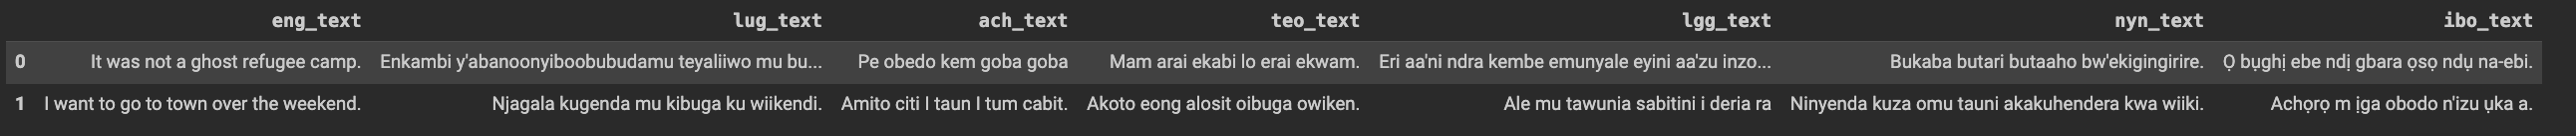



This will make it easier to pull and train with.

### Prepare MT560 data

This is a big dataset, around 35GB compressed. So filter it by selecting the languages of interest, using the language codes for example: `lug` (Luganda), `ach` (Acholi), `nyn` (Runyankore), `ibo` (igbo) or `yor` (hausa), etc.

In [3]:
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 5.9 MB/s eta 0:00:00


In [4]:
import gzip
import io
from IPython import display
import numpy as np
import pandas as pd
import tqdm
import sacremoses

display.clear_output()

In [5]:
import pandas as pd
import numpy as np

!wget https://object.pouta.csc.fi/OPUS-MT560/train.v1.lang.gz

languages = pd.read_csv('train.v1.lang.gz', engine='c', names=['code'])
num_lines = len(languages)

language_codes = ['ach', 'nyn'] # list as many lanaguges of your interest that are available in MT560
line_languages = {}
for code in language_codes:
  lines = np.where(languages.code == code)[0]
  for l in lines:
    line_languages[l] = code

display.clear_output()

In [6]:
for code in language_codes:
  N = sum(value == code for value in line_languages.values())
  print(f'{N} lines of language {code}')

73172 lines of language ach
50379 lines of language nyn


If that looks OK, then remove unnecessary files and variables to make space for iterating over the full dataset.

In [7]:
del languages
!rm train.v1.lang*

Now retrieve the actual sentences. This should take ~30 minutes to download and ~50 minutes to iterate over.

In [2]:
!wget https://object.pouta.csc.fi/OPUS-MT560/train.v1.eng.tok.gz
!wget https://object.pouta.csc.fi/OPUS-MT560/train.v1.src.tok.gz
display.clear_output()

--2024-02-05 09:23:00--  https://object.pouta.csc.fi/OPUS-MT560/train.v1.eng.tok.gz
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19039551035 (18G) [application/gzip]
Saving to: ‘train.v1.eng.tok.gz’

train.v1.eng.tok.gz 100%[===================>]  17.73G  18.7MB/s    in 16m 36s 

2024-02-05 09:39:37 (18.2 MB/s) - ‘train.v1.eng.tok.gz’ saved [19039551035/19039551035]



In [8]:
source = []
language = []

with gzip.open('train.v1.src.tok.gz','r') as f:
  for i, line in tqdm.tqdm(enumerate(f), total=num_lines):
    if i in line_languages:
      source.append(line)
      language.append(line_languages[i])

100%|██████████| 473791770/473791770 [12:29<00:00, 632264.63it/s]


In [9]:
english = []

with gzip.open('train.v1.eng.tok.gz','r') as f:
  for i, line in tqdm.tqdm(enumerate(f), total=num_lines):
    if i in line_languages:
      english.append(line)

100%|██████████| 473791770/473791770 [11:20<00:00, 696031.76it/s]


In [10]:
detokenizer = sacremoses.MosesDetokenizer(lang='en')
source_detokenized = []
english_detokenized = []
for i in tqdm.tqdm(range(len(source)), position=0):
  source_detokenized.append(
      detokenizer.detokenize([source[i].decode('utf8')]))
  english_detokenized.append(
      detokenizer.detokenize([english[i].decode('utf8')]))

100%|██████████| 123551/123551 [00:09<00:00, 12569.09it/s]


In [13]:
data = pd.DataFrame()
data['source'] = source_detokenized
data['english'] = english_detokenized
data['source_language'] = language

data.sample(n=10)

,source,english,source_language
58061,38: 23) Kit macalo jo Icrael gudonyo i Lobo ma...,And just as surely as his ancient people inher...,ach
85217,"Ti pi Jehovah Labongo Koko Ange, 1 / 1","For Those Loving Jehovah, ""There Is No Stumbli...",ach
76968,"Kwonka okumanya ekyo, kikaba kitarikumara.","Knowledge, though, was not enough.",nyn
109190,Okwijuka okufa kwa Yesu omu muringo ogwo buri ...,Commemorating Jesus' death that way each year ...,nyn
25723,Pingo watwero bedo ki mar matut i kom Lubanga?,Why can we have deep love for God?,ach
62207,Pe myero waye gin mo keken ogengwa ki nongo te...,Let us never allow other pursuits and activiti...,ach
123431,"Pi cencwari mapol, lupwonye dini gubedo ka pwo...","For centuries, religious leaders have taught t...",ach
68141,"Ento ka iporo ki Paulo, jo ma gilubo ""kit me k...","Unlike him, however, those who ""are in accord ...",ach
31355,Ahabw'okuba oburemeezi bwaitu obumwe nibubaho ...,Because some of our problems are the result of...,nyn
13433,Nitubaasa kubatooreza tuta?,How can we imitate them?,nyn


In [32]:
# rename the columns to be of this format {lang}_text and save data
for l in language_codes:
  d = data[data["source_language"] == l]
  print(f"{l}: ", len(d))
  d.drop(columns="source_language", inplace=True)
  d.rename(columns={
      "source": f"{l}_text",
      "english": "eng_text"
  }, inplace=True)
  print(d.columns, "\n")
  d.to_parquet(f'mt560_{l}.parquet', index=False)


ach:  73172
Index(['ach_text', 'eng_text'], dtype='object') 

nyn:  50379
Index(['nyn_text', 'eng_text'], dtype='object') 



<ipython-input-32-6b91dbe54080>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.drop(columns="source_language", inplace=True)
<ipython-input-32-6b91dbe54080>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.rename(columns={
<ipython-input-32-6b91dbe54080>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.drop(columns="source_language", inplace=True)
<ipython-input-32-6b91dbe54080>:6: SettingWithCopyWarning: 
A value is trying to 

### Convert the data to HuggingFace Dataset Object and write to the hub.

In [19]:
%%capture
!pip install datasets

In [20]:
import datasets
import huggingface_hub

# enter huggingface token in the prompt that will be generated.
huggingface_hub.notebook_login()

In [33]:
import os
data_files = os.listdir(".")

# push all data in the directory to your huggingface hub.
# set private to True to store as a private data.
username = "sharonibejih"
repo_name = "demo_sample_mt560_datasets"

for data_f in data_files:
  if data_f.endswith("parquet"):
    dataset = datasets.Dataset.from_parquet("./"+data_f)

    dataset.push_to_hub(f'{username}/{repo_name}', data_f, private=True)
    print(f"pushed {data_f}")


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/74 [00:00<?, ?ba/s]

pushed mt560_ach.parquet


Generating train split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/51 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/374 [00:00<?, ?B/s]

pushed mt560_nyn.parquet


### Test the successful push

In [42]:
test_push = datasets.load_dataset(f'{username}/{repo_name}', 'mt560_ach.parquet', split='train')
list(test_push)

Generating train split:   0%|          | 0/73172 [00:00<?, ? examples/s]

[{'ach_text': 'I mwaka me apar wiye angwen me loc pa kabaka Kejekia en aye Cenakarib kabaka me Aciria obino kwede ka lweny i kom gangi ducu me Juda ma girumogi ki cel gogo, ci omayogi ducu.',
  'eng_text': 'In the fourteenth year of King Hezekiah, Sennacherib the king of Assyria came up against all the fortified cities of Judah and proceeded to seize them.'},
 {'ach_text': '"Atyeko coyo lok ma romo pyeradek kun amiyi tam mabeco kacel ki ngec muromo, pi nyuto boti gin ma atir dok ada." - CAROLOK 22: 20, 21.',
  'eng_text': '"Have I not written you heretofore with counselings and knowledge, to show you the truthfulness of true sayings, so as to return sayings that are the truth?" - PROVERBS 22: 20, 21.'},
 {'ach_text': '"Pe tye dano mo ma bedo i lobowa ma biwaco ni, \'An koma lit.\'" - ICAYA 33: 24.',
  'eng_text': '"No resident will say: \'I am sick.\'" - ISAIAH 33: 24.'},
 {'ach_text': '"Watyeko nongo Meciya." - JON 1: 41.',
  'eng_text': '"We have found the Messiah." - JOHN 1: 41.'},
